## 7.7 Densely Connected Networks(DenseNet)
### 7.7.1 From ResNet to DenseNet

In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

In [2]:
# 7.7.2 Dense Blocks
def conv_block(num_channels):
    # 稠密块：输入和输出是如何连结的
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=3, padding=1))
    return blk

In [3]:
class DenseBlock(nn.Block):
    def __init__(self, num_convs, num_channels, **kwargs):
        super(DenseBlock, self).__init__(**kwargs)
        self.net = nn.Sequential()
        for _ in range(num_convs):
            self.net.add(conv_block(num_channels))

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = np.concatenate((X, Y), axis=1)
        return X

In [4]:
X = np.random.uniform(size=(4, 3, 8, 8))

blk = DenseBlock(2, 10)
blk.initialize()
Y = blk(X)
print(Y.shape)

(4, 23, 8, 8)


In [5]:
# 7.7.3 Transition Layers
def transition_block(num_channels):
    # 过渡层：控制通道数目，使之不要过大
    blk = nn.Sequential()
    blk.add(nn.BatchNorm(),
            nn.Activation('relu'),
            nn.Conv2D(num_channels, kernel_size=1),
            nn.AvgPool2D(pool_size=2, strides=2))
    return blk

In [6]:
blk = transition_block(10)
blk.initialize()
print(blk(Y).shape)

(4, 10, 4, 4)


In [7]:
# 7.7.4 DenseNet Model
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    net.add(DenseBlock(num_convs, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_convs_in_dense_blocks) - 1:
        num_channels //= 2
        net.add(transition_block(num_channels))
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))

In [8]:
from tools import net_details

X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize(force_reinit=True)
net_details(X, net)

conv3 output shape:	 (1, 64, 48, 48)
batchnorm3 output shape:	 (1, 64, 48, 48)
relu3 output shape:	 (1, 64, 48, 48)
pool1 output shape:	 (1, 64, 24, 24)
denseblock1 output shape:	 (1, 192, 24, 24)
sequential10 output shape:	 (1, 96, 12, 12)
denseblock2 output shape:	 (1, 224, 12, 12)
sequential16 output shape:	 (1, 112, 6, 6)
denseblock3 output shape:	 (1, 240, 6, 6)
sequential22 output shape:	 (1, 120, 3, 3)
denseblock4 output shape:	 (1, 248, 3, 3)
batchnorm23 output shape:	 (1, 248, 3, 3)
relu23 output shape:	 (1, 248, 3, 3)
pool5 output shape:	 (1, 248, 1, 1)
dense0 output shape:	 (1, 10)


loss 0.068, train acc 0.975, test acc 0.875
926.4 examples/sec on gpu(0)


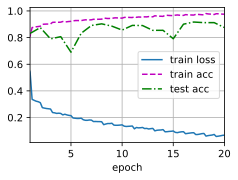

In [9]:
lr, num_epochs, batch_size = 0.1, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [9]:
class Residual(nn.Block):
    """The Residual block of ResNet."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3: X = self.conv3(X)
        return npx.relu(Y + X)

In [10]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

In [11]:
# DenseNet + ResNet
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
net.add(resnet_block(64, 1, first_block=True),
        DenseBlock(4, 32),
        transition_block(96),
        resnet_block(96, 1, first_block=True),
        DenseBlock(4, 32),
        transition_block(112),
        resnet_block(112, 1, first_block=True),
        DenseBlock(4, 32),
        transition_block(120),
        resnet_block(120, 1, first_block=True),
        DenseBlock(4, 32))
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))
net.initialize(force_reinit=True)
net_details(X, net)        

conv23 output shape:	 (1, 64, 48, 48)
batchnorm24 output shape:	 (1, 64, 48, 48)
relu24 output shape:	 (1, 64, 48, 48)
pool6 output shape:	 (1, 64, 24, 24)
sequential29 output shape:	 (1, 64, 24, 24)
denseblock5 output shape:	 (1, 192, 24, 24)
sequential35 output shape:	 (1, 96, 12, 12)
sequential36 output shape:	 (1, 96, 12, 12)
denseblock6 output shape:	 (1, 224, 12, 12)
sequential42 output shape:	 (1, 112, 6, 6)
sequential43 output shape:	 (1, 112, 6, 6)
denseblock7 output shape:	 (1, 240, 6, 6)
sequential49 output shape:	 (1, 120, 3, 3)
sequential50 output shape:	 (1, 120, 3, 3)
denseblock8 output shape:	 (1, 248, 3, 3)
batchnorm52 output shape:	 (1, 248, 3, 3)
relu44 output shape:	 (1, 248, 3, 3)
pool10 output shape:	 (1, 248, 1, 1)
dense1 output shape:	 (1, 10)


loss 0.021, train acc 0.993, test acc 0.924
757.8 examples/sec on gpu(0)


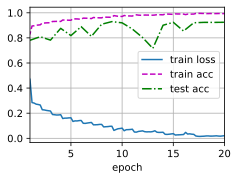

In [13]:
lr, num_epochs, batch_size = 0.1, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [12]:
# DenseNet + ResNet
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
net.add(resnet_block(64, 2, first_block=True),
        DenseBlock(4, 32),
        transition_block(96),
        resnet_block(96, 2, first_block=True),
        DenseBlock(4, 32),
        transition_block(112),
        resnet_block(112, 2, first_block=True),
        DenseBlock(4, 32),
        transition_block(120),
        resnet_block(120, 2, first_block=True),
        DenseBlock(4, 32))
net.add(nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))
net.initialize(force_reinit=True)
net_details(X, net)        

conv51 output shape:	 (1, 64, 48, 48)
batchnorm53 output shape:	 (1, 64, 48, 48)
relu45 output shape:	 (1, 64, 48, 48)
pool11 output shape:	 (1, 64, 24, 24)
sequential57 output shape:	 (1, 64, 24, 24)
denseblock9 output shape:	 (1, 192, 24, 24)
sequential63 output shape:	 (1, 96, 12, 12)
sequential64 output shape:	 (1, 96, 12, 12)
denseblock10 output shape:	 (1, 224, 12, 12)
sequential70 output shape:	 (1, 112, 6, 6)
sequential71 output shape:	 (1, 112, 6, 6)
denseblock11 output shape:	 (1, 240, 6, 6)
sequential77 output shape:	 (1, 120, 3, 3)
sequential78 output shape:	 (1, 120, 3, 3)
denseblock12 output shape:	 (1, 248, 3, 3)
batchnorm89 output shape:	 (1, 248, 3, 3)
relu65 output shape:	 (1, 248, 3, 3)
pool15 output shape:	 (1, 248, 1, 1)
dense2 output shape:	 (1, 10)


loss 0.023, train acc 0.992, test acc 0.903
597.9 examples/sec on gpu(0)


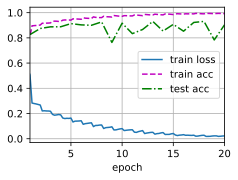

In [14]:
lr, num_epochs, batch_size = 0.1, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [13]:
# DenseNet + ResNet
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))
net.add(resnet_block(64, 1, first_block=True),
        DenseBlock(4, 32),
        resnet_block(192, 1),
        DenseBlock(4, 32),
        resnet_block(320, 1),
        DenseBlock(4, 32),
        resnet_block(448, 1),
        nn.BatchNorm(),
        nn.Activation('relu'),
        nn.GlobalAvgPool2D(),
        nn.Dense(10))
net.initialize(force_reinit=True)
net_details(X, net)        

conv87 output shape:	 (1, 64, 48, 48)
batchnorm90 output shape:	 (1, 64, 48, 48)
relu66 output shape:	 (1, 64, 48, 48)
pool16 output shape:	 (1, 64, 24, 24)
sequential85 output shape:	 (1, 64, 24, 24)
denseblock13 output shape:	 (1, 192, 24, 24)
sequential91 output shape:	 (1, 192, 12, 12)
denseblock14 output shape:	 (1, 320, 12, 12)
sequential97 output shape:	 (1, 320, 6, 6)
denseblock15 output shape:	 (1, 448, 6, 6)
sequential103 output shape:	 (1, 448, 3, 3)
batchnorm111 output shape:	 (1, 448, 3, 3)
relu79 output shape:	 (1, 448, 3, 3)
pool17 output shape:	 (1, 448, 1, 1)
dense3 output shape:	 (1, 10)


loss 0.000, train acc 1.000, test acc 0.938
589.6 examples/sec on gpu(0)


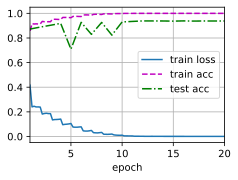

In [14]:
lr, num_epochs, batch_size = 0.1, 20, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)